In [1]:
import BioSimSpace as BSS
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
import glob
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
import shutil
from functools import reduce
from rdkit import Chem

In [2]:
def generateLinksFiles(preds_path):
    """Given a csv file with SEM predictions, write out links files for LOMAP.
    Because SEMs are the inverse of LOMAP (i.e. LOMAP-score 0.0 is poor, but SEM 0.0 is good), 
    we need to invert the predicted SEM values. Additionally, compress them to fall in the range 0-1 
    as is the case with LOMAP-scores."""
    
    preds_df = pd.read_csv(preds_path)
    pert_names = preds_df["pert_name"].values
    
    # for these, take inverse and scale to 0-1.
    pred_sems = minmax_scale(1 / preds_df["pred_sem_mean"].values, feature_range=(0,1))
    
    random_sems = preds_df["random_sem"].values
    return pert_names, pred_sems, random_sems
        
def writeLinksFile(pert_names, values, filename):
    with open(filename, "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
        for pert_name, value in zip(pert_names, values):
            writer.writerow([pert_name, value])
        

In [21]:
def runLOMAP(tgt, plot_network=False, links_file=False):
    path_to_ligands = f"/home/jscheen/projects/FEPSPACE/fep_ref_ligands/{tgt}"
    ligand_files = glob.glob(f"{path_to_ligands}/*.sdf")

    ligands = []
    ligand_names = []

    for filepath in ligand_files:
        # append the molecule object to a list.
        ligands.append(Chem.SDMolSupplier(filepath)[0])

        # append the molecule name to another list so that we can use the name of each molecule in our workflow.
        ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))
    
    # now run LOMAP. Even if we have a links_file, we need to run a 'vanilla' LOMAP first to get the work dir.
    if links_file:
        tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=False, names=ligand_names,
                                                            work_dir="tmp/lomap_workdir")       
    else:
        tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=plot_network, names=ligand_names,
                                                            work_dir="tmp/lomap_workdir")

    if links_file:
        links_file = f"tmp/lomap_ml_links_file_{tgt}.csv"
        # bit of a workaround, but we have to find the mol2 file names that LOMAP uses internally.  
        # write out a second linksfile that doesn't have the tilde to denote the perturbations. Also
        # use glob in the pre-generated LOMAP work folder to find what we should call our ligands (i.e.
        # refer to the internal LOMAP file name).
        links_file_contents = pd.read_csv(links_file, sep=" ", header=None)
        lomap_internal_files = glob.glob("tmp/lomap_workdir/inputs/*.sdf")
        internal_links_file_path = links_file.replace(".csv", "_internal.csv")

        with open(internal_links_file_path, "w") as writefile:
            writer = csv.writer(writefile, delimiter =" ")
            lig1, lig2 = None, None
            for pert_name, value in zip(links_file_contents[0].values, links_file_contents[1].values):
                # find the internal path.
                for lig in lomap_internal_files:
                    if pert_name.split("~")[0] in lig:
                        lig1 = lig.split("/")[-1]
                    elif pert_name.split("~")[1] in lig:
                        lig2 = lig.split("/")[-1]
                if lig1 and lig2:
                    writer.writerow([lig1, lig2, value])



        # now run LOMAP with the pre-specified edge scorings.
        tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=plot_network, names=ligand_names,
                                                                links_file=internal_links_file_path)    

    pert_network_dict = {}
    transformations_named = [(ligand_names[transf[0]], ligand_names[transf[1]]) for transf in tranformations]
    for transf, score in zip(transformations_named, lomap_scores):
        transf_tilde = "~".join(transf)
        pert_network_dict[transf_tilde] = score
        print(transf_tilde)

    return tranformations, lomap_scores, pert_network_dict, ligand_names

In [22]:
def compareNetworks(tgt_to_do, print_overlapping_edges=False, plot_network=False):
    # clear all links files from ./tmp.
    [os.remove(linkspath) for linkspath in glob.glob("tmp/lomap*.csv")]
    shutil.rmtree("tmp/lomap_workdir", ignore_errors=True)
    
    # get the links files for this target.
    sem_preds_files = []
    
    for sem_preds_file in glob.glob(f"output/series_predictions/{tgt_to_do}_*csv"):
        if not "perts" in sem_preds_file and not "_networks" in sem_preds_file:
            sem_preds_files.append(sem_preds_file)
    pred_sems_coll = []
    for sem_preds_file in sem_preds_files:
        pert_names, pred_sems, _ = generateLinksFiles(sem_preds_file)
        pred_sems_coll.append(pred_sems)
        
    
    # compute mean pred_sems.
    pred_sems = np.mean(pred_sems_coll, axis=0)
                
                
    # generate networks.      
    writeLinksFile(pert_names, pred_sems, f"tmp/lomap_ml_links_file_{tgt_to_do}.csv")

    print("LOMAP-Score:")
    transformations_lomap, _, _, lig_names = runLOMAP(tgt_to_do, plot_network, links_file=False)
    print("RBFENN:")
    transformations_fepnn, _, _, lig_names = runLOMAP(tgt_to_do, plot_network, links_file=True)
    
    if print_overlapping_edges:
        print("Overlapping edges:")
        for transf in transformations_lomap:
            inv_transf = (transf[1], transf[0])
            if transf in transformations_fepnn or inv_transf in transformations_fepnn:
                print(f"{lig_names[transf[0]]}~{lig_names[transf[1]]}")
    
    return transformations_lomap, transformations_fepnn, len(lig_names)


In [23]:
def computeNetworkOverlap(transformations_lomap, transformations_fepnn):
    overlap = 0

    for edge_lomap in transformations_lomap:
        
        inv_edge = (edge_lomap[1], edge_lomap[0])
        if edge_lomap in transformations_fepnn:

            overlap += 1
        elif inv_edge in transformations_fepnn:
            overlap += 1


    if overlap == 0:
        perc_overlap = 0
    else:
        perc_overlap_lomap = int(overlap/len(transformations_lomap)*100)
        perc_overlap_fepnn = int(overlap/len(transformations_fepnn)*100)
        perc_overlap = np.mean([perc_overlap_lomap, perc_overlap_fepnn])

    return len(transformations_lomap), int(perc_overlap), len(transformations_fepnn)


LOMAP-Score:
lig_05_ligOEt~lig_02_ligOMe
lig_05_ligOEt~lig_03_ligNHMe
lig_04_ligNMe2~lig_02_ligOMe
lig_04_ligNMe2~lig_03_ligNHMe
lig_02_ligOMe~lig_07_ligOH
lig_01_ligF~lig_06_ligPyr
lig_01_ligF~lig_07_ligOH
lig_01_ligF~lig_08_ligNH2
lig_06_ligPyr~lig_07_ligOH
lig_03_ligNHMe~lig_08_ligNH2
RBFENN:
lig_05_ligOEt~lig_04_ligNMe2
lig_05_ligOEt~lig_01_ligF
lig_05_ligOEt~lig_07_ligOH
lig_04_ligNMe2~lig_03_ligNHMe
lig_02_ligOMe~lig_01_ligF
lig_02_ligOMe~lig_07_ligOH
lig_02_ligOMe~lig_08_ligNH2
lig_06_ligPyr~lig_07_ligOH
lig_06_ligPyr~lig_03_ligNHMe
lig_03_ligNHMe~lig_08_ligNH2
Overlapping edges:
lig_04_ligNMe2~lig_03_ligNHMe
lig_02_ligOMe~lig_07_ligOH
lig_06_ligPyr~lig_07_ligOH
lig_03_ligNHMe~lig_08_ligNH2


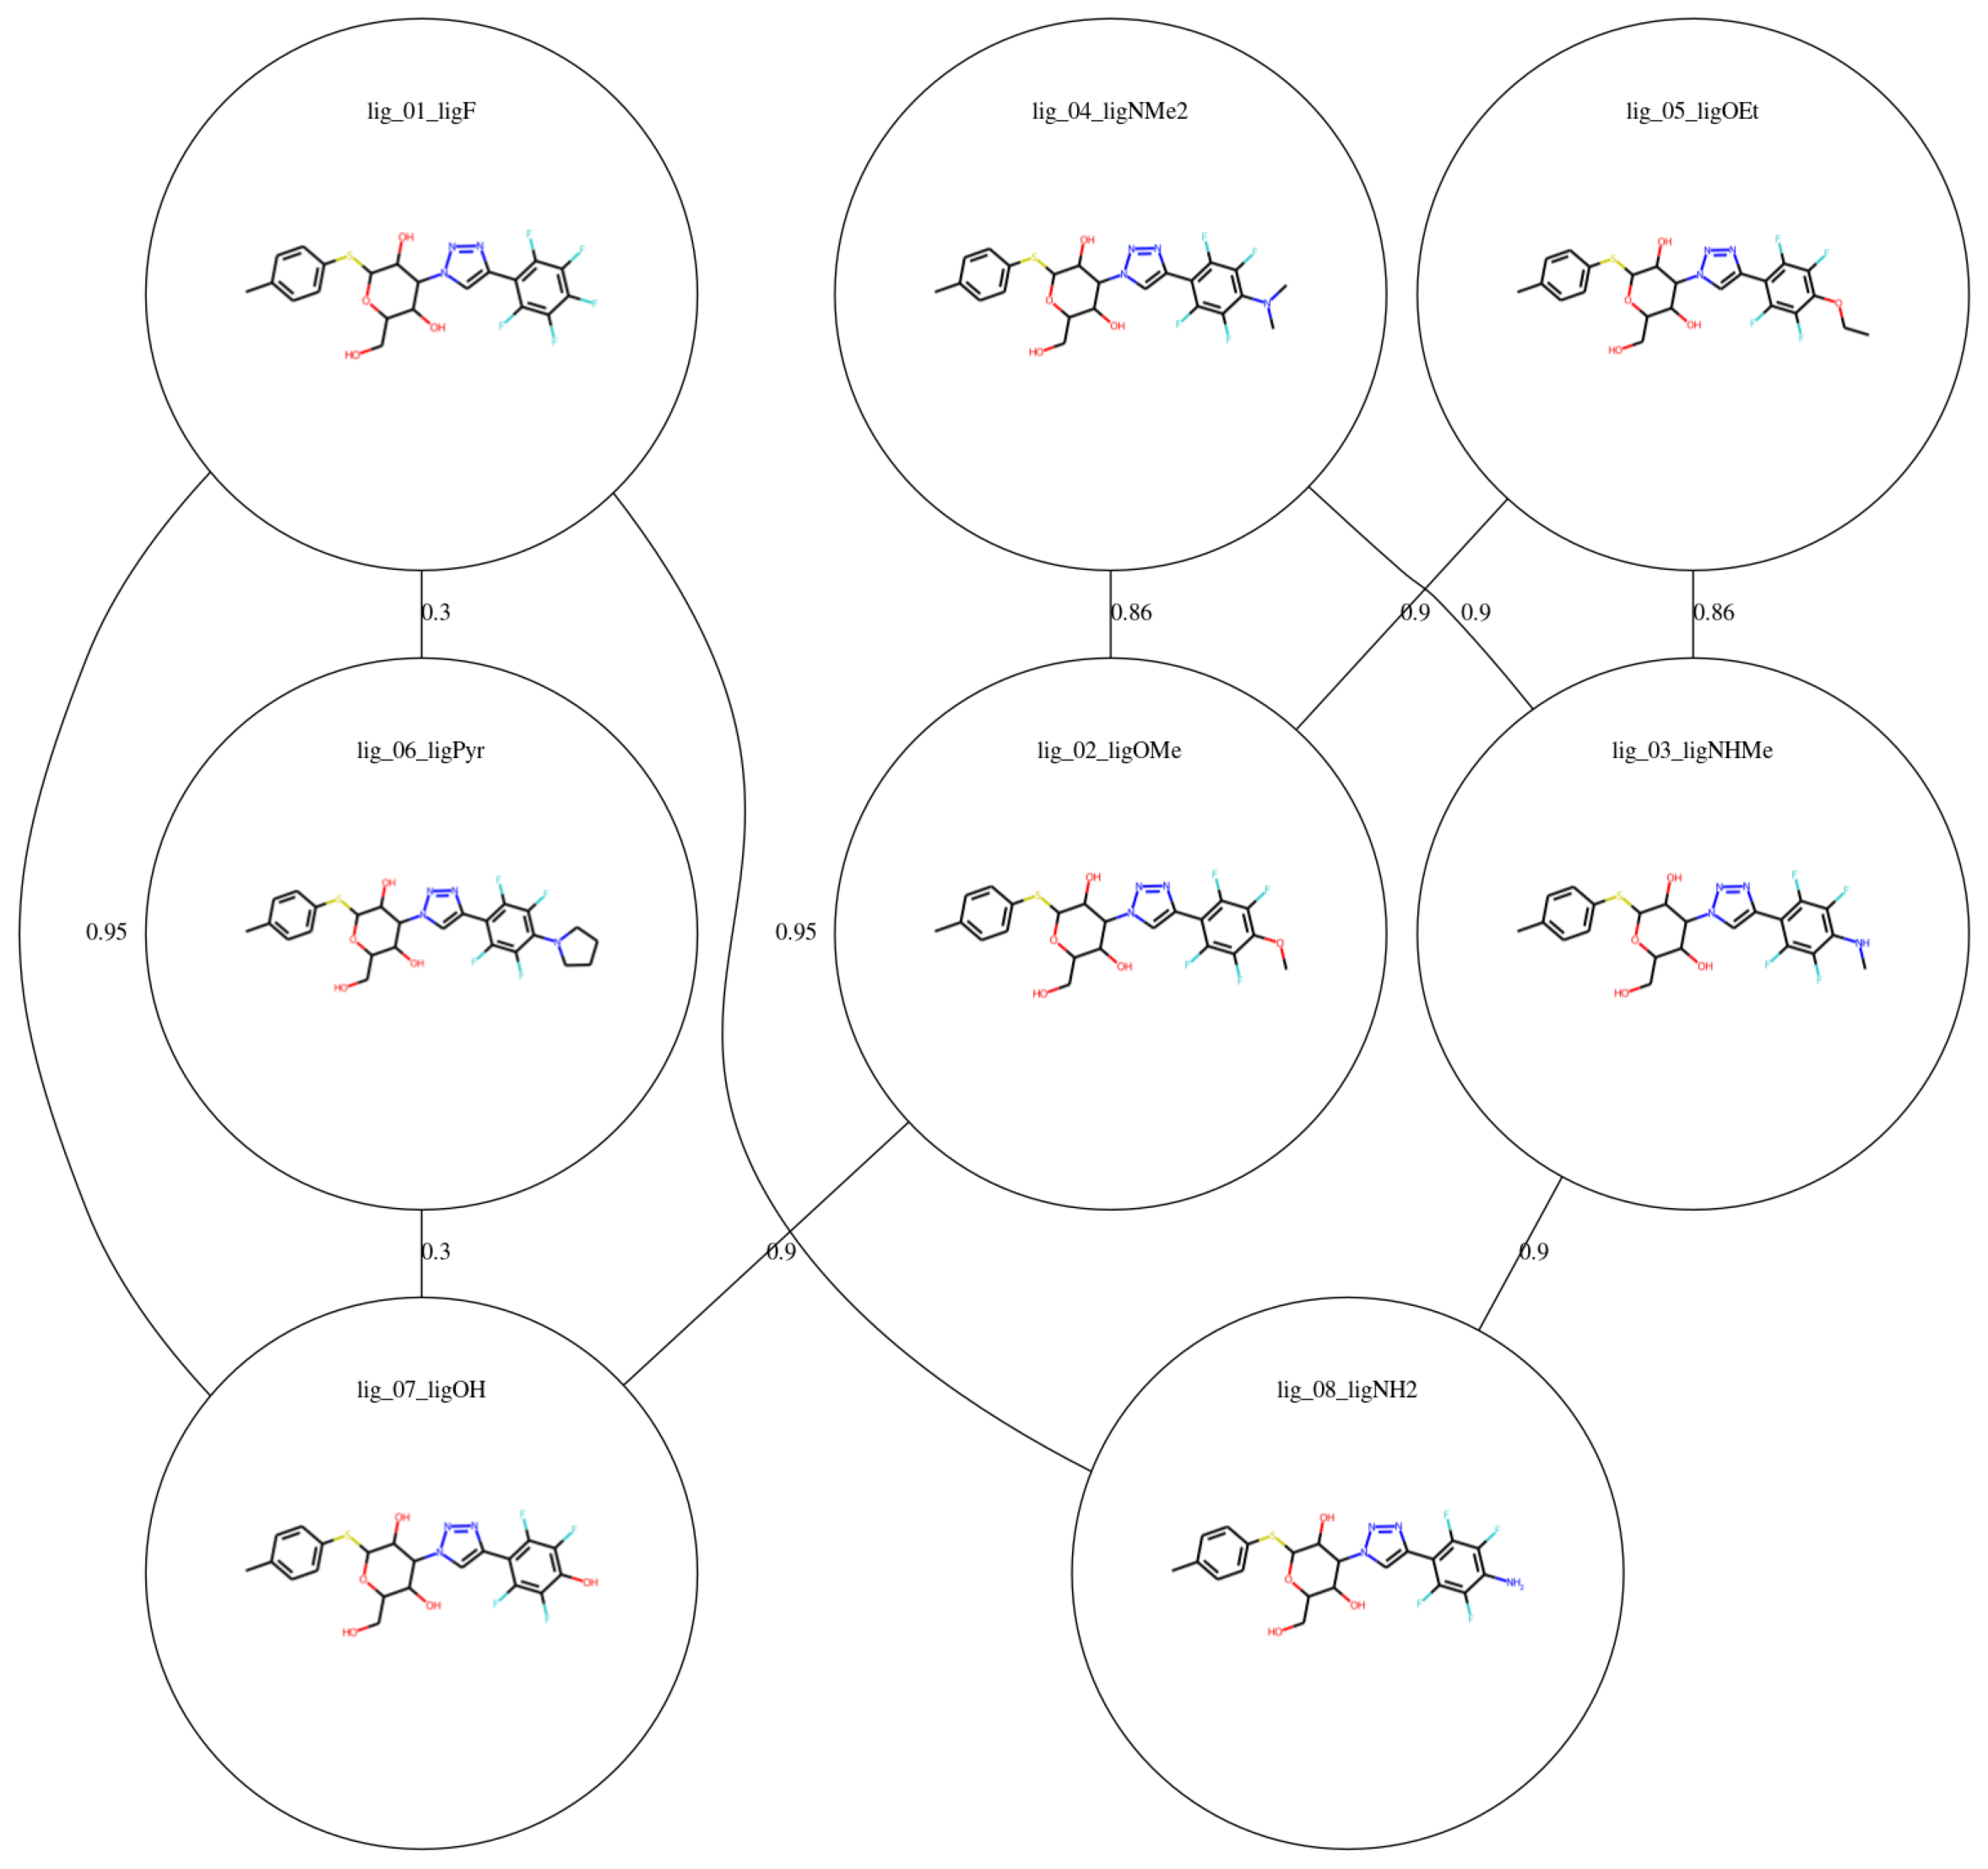

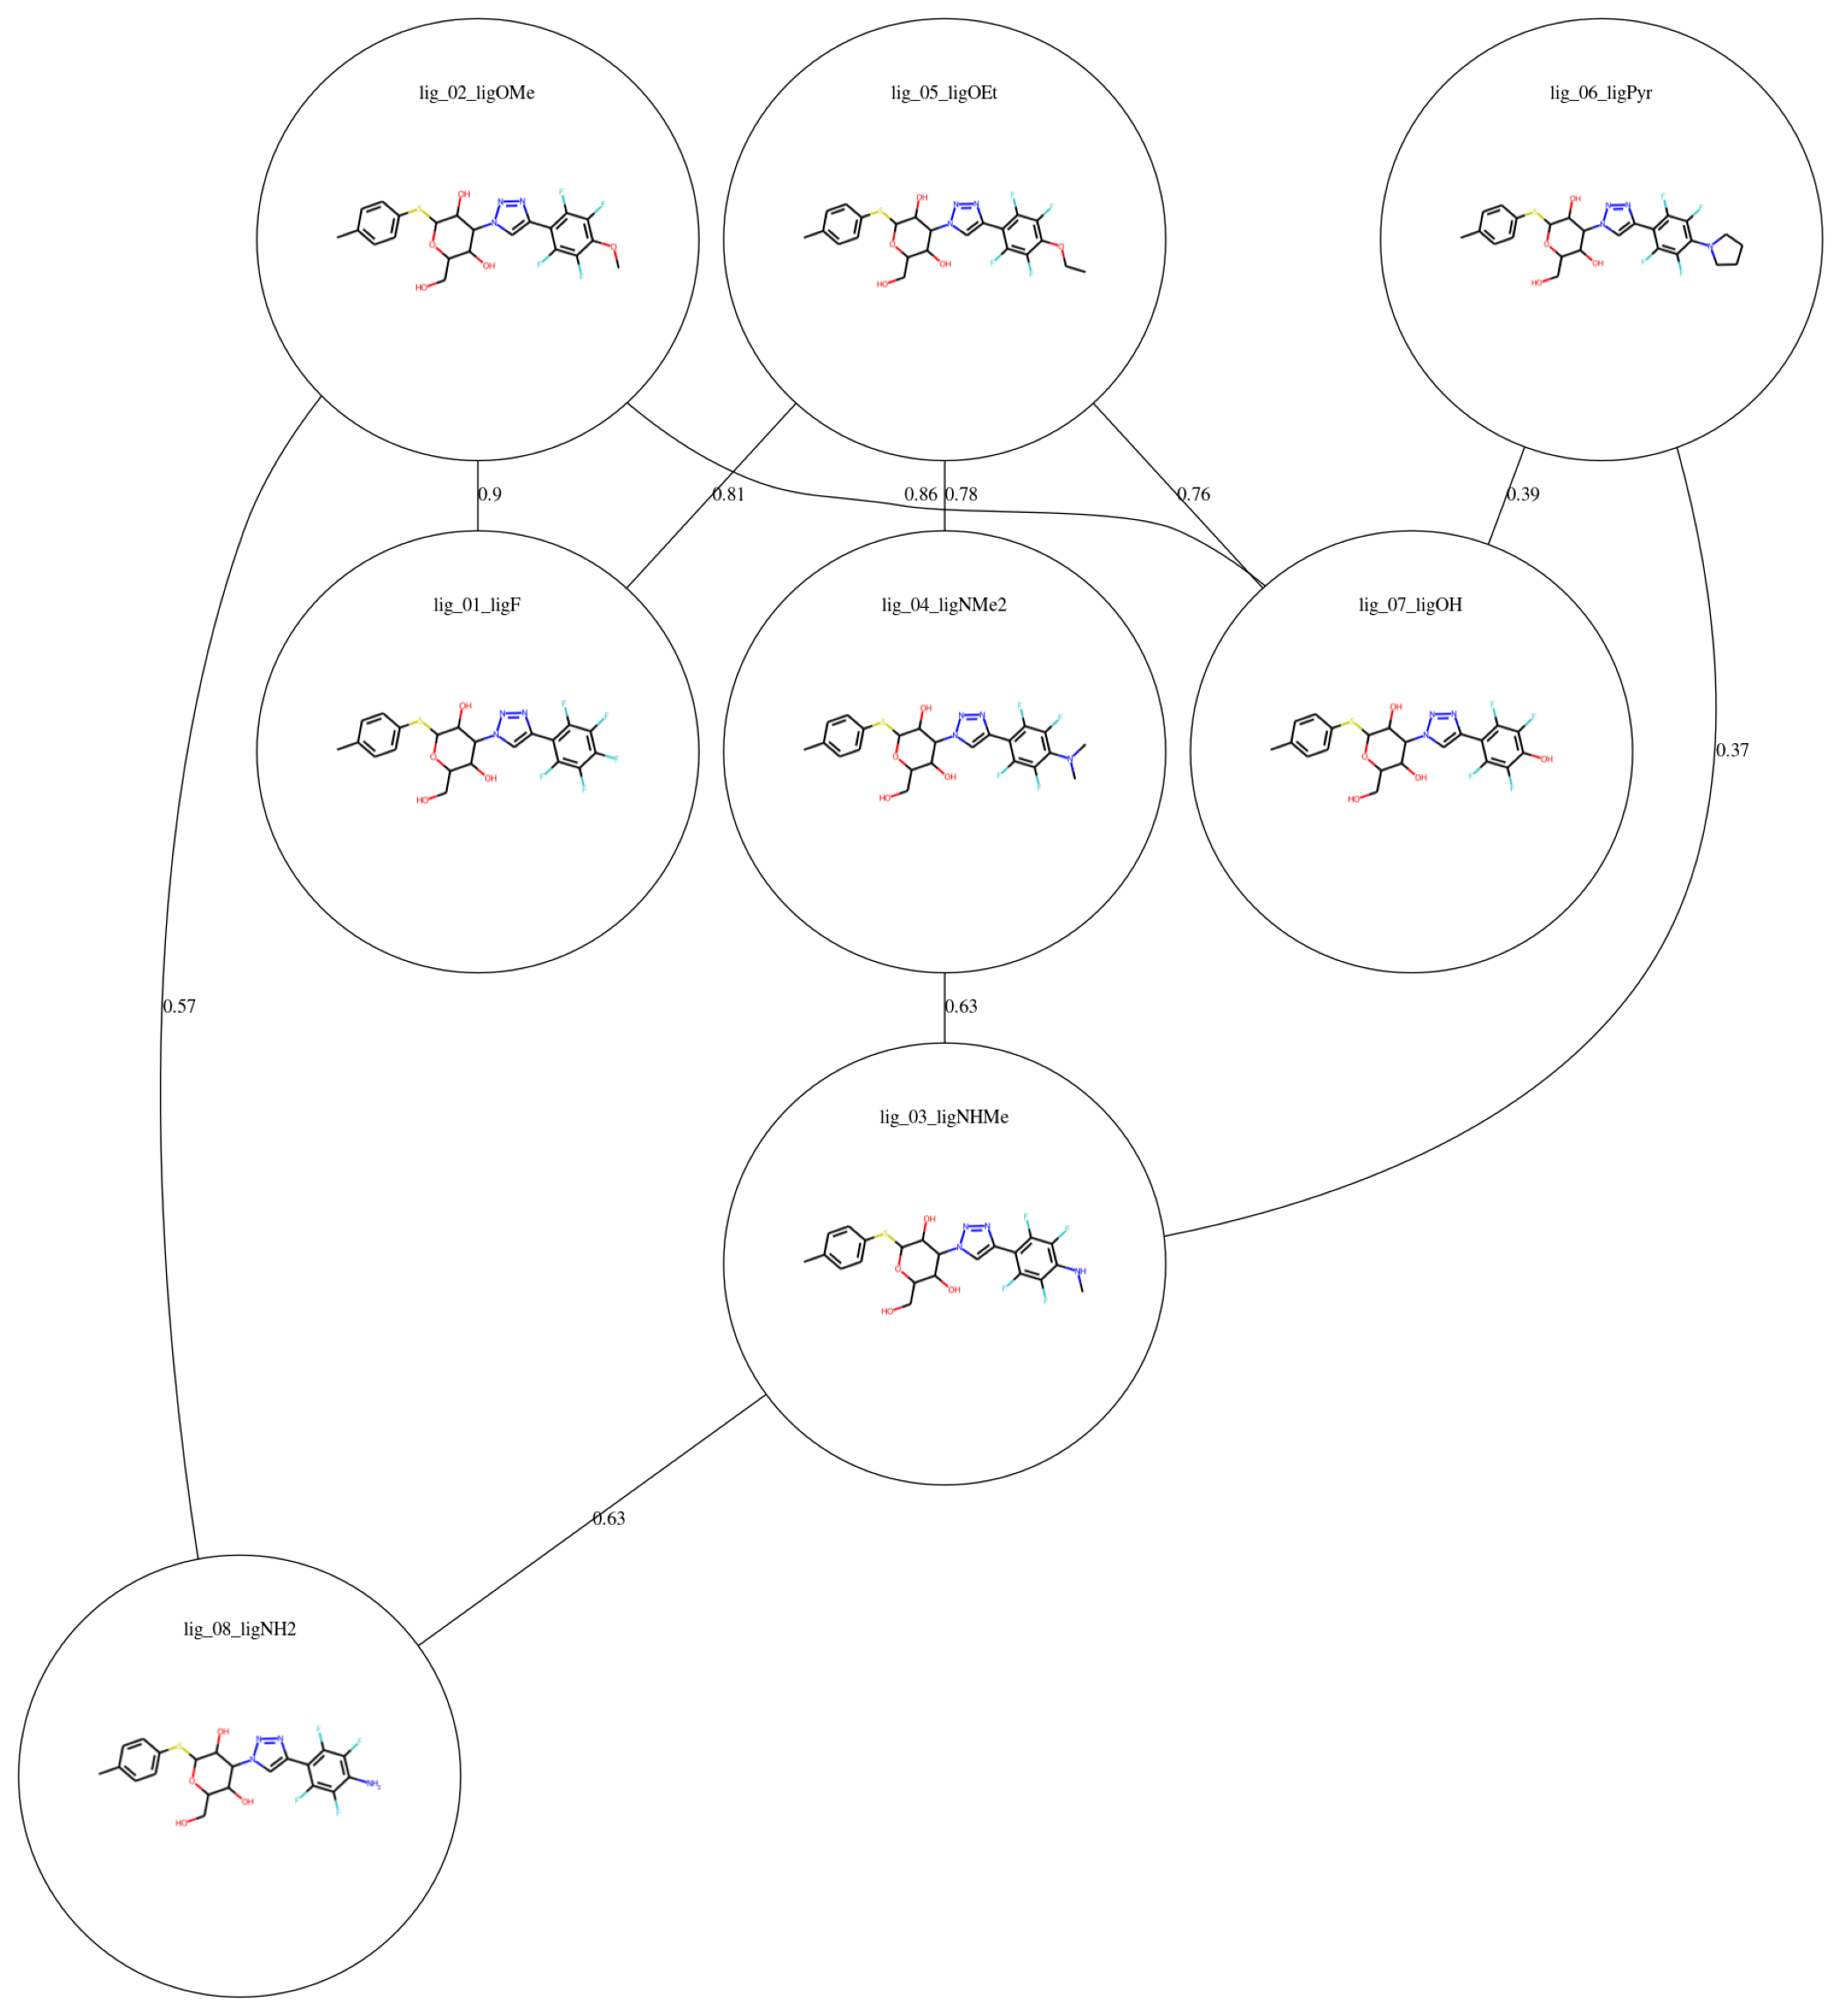

In [24]:
tgt = "galectin" 

transformations_lomap, transformations_fepnn, num_ligs = compareNetworks(tgt, print_overlapping_edges=True, plot_network=True)
num_lomap, overlap, num_fepnn = computeNetworkOverlap(transformations_lomap, transformations_fepnn)




In [16]:
overlap

40